# Simulating phenotypes

- Mock example with very small sample size and number of SNPs
- Simple example using 2 components (genetic and noise), and bi-allelic SNPs
- Frequencies to sample alleles: 0.1, 0.2, 0.3

In [263]:
# load libraries
library(data.table)
library(PhenotypeSimulator)

In [264]:
# simulate simple bi-allelic genotypes 
# 100 people, 30 SNP
# Allele frequencies 0.1, 0.2, 0.3, we need to think about better values for this
nsim = 100
genotypes = simulateGenotypes(N = nsim, NrSNP = 30, 
        frequencies = c(0.1, 0.2, 0.3), verbose = FALSE)
names(genotypes)

[1] "genotypes"  "freq"       "id_snps"    "id_samples"

In [265]:
# this is pretty simple, it just create fake SNP with a given allele frequencies
head(genotypes$genotypes)

,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,SNP_8,SNP_9,SNP_10,⋯,SNP_21,SNP_22,SNP_23,SNP_24,SNP_25,SNP_26,SNP_27,SNP_28,SNP_29,SNP_30
ID_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,1
ID_2,1,0,1,0,0,1,0,0,0,0,⋯,0,1,0,1,1,2,0,1,1,0
ID_3,1,1,1,0,0,1,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,1
ID_4,1,1,2,0,0,2,2,1,0,0,⋯,1,0,0,0,0,0,0,0,0,1
ID_5,0,0,0,0,1,1,1,0,0,0,⋯,0,0,0,1,0,1,1,0,0,0
ID_6,2,1,1,0,1,1,0,0,0,0,⋯,0,0,0,0,1,1,1,0,0,0


In [266]:
# then, we can assign (randomly) causal SNP to that matrix
# and genetic effects
# P = number of traits simulated, in this case only one
causalSNPs = getCausalSNPs(N = nsim, genotypes = genotypes$genotypes, 
    NrCausalSNPs = 10, verbose = FALSE)
genFixed <- geneticFixedEffects(N = nsim, P = 1, X_causal = causalSNPs, 
    pIndependentGenetic = 1) 
# effects simulated for the causal SNP selected (a fake GWAS)
t(genFixed$cov_effect)


,Trait_1
independentEffect1_SNP_2,2.51263847
independentEffect2_SNP_4,0.17965633
independentEffect3_SNP_5,-0.54696725
independentEffect4_SNP_8,0.12497527
independentEffect5_SNP_9,-0.60206605
independentEffect6_SNP_12,-0.05686761
independentEffect7_SNP_14,0.10039204
independentEffect8_SNP_18,-1.62474934
independentEffect9_SNP_20,-0.74297686
independentEffect10_SNP_29,-0.99985231


In [267]:
# to simulate the phenotype we need to define other factors
# in this case I am just adding noise, but we can add effect of covariates, culture, etc.
# I am only using independent effect because we are using only one trait.
noiseBg = noiseBgEffects(N = nsim, P = 1, share = FALSE)
t(noiseBg$cov_independent)


1.275785


In [268]:
# to define the phenotype we set parameters on the variance composition of the phenotype

# parameters (pretty simple example)
genVar = 0.3 # genetic variability
noiseVar <- 1 - genVar # noise variability 

# rescale phenotype components so that variance composition match parameters above
genFixed_independent_scaled = rescaleVariance(genFixed$independent, genVar)
noiseBg_independent_scaled <- rescaleVariance(noiseBg$independent, noiseVar)

# total variance proportion shave to add up yo 1
total <-  noiseVar + genVar
total == 1

[1] TRUE

In [269]:
noiseBg_independent_scaled$component[c(30, 40)]
noiseBg$independent[c(30, 40)]

[1]  0.9078097 -1.7564358

[1]  1.231466 -2.382649

In [270]:
genFixed_independent_scaled$component[c(30, 40)]
genFixed$independent[c(30, 40)]

[1] -0.3231795  0.1337077

[1] -1.149033  0.475385

    Trait_1         
 Min.   :-2.272308  
 1st Qu.:-0.507009  
 Median :-0.001182  
 Mean   : 0.093612  
 3rd Qu.: 0.636727  
 Max.   : 2.269225  

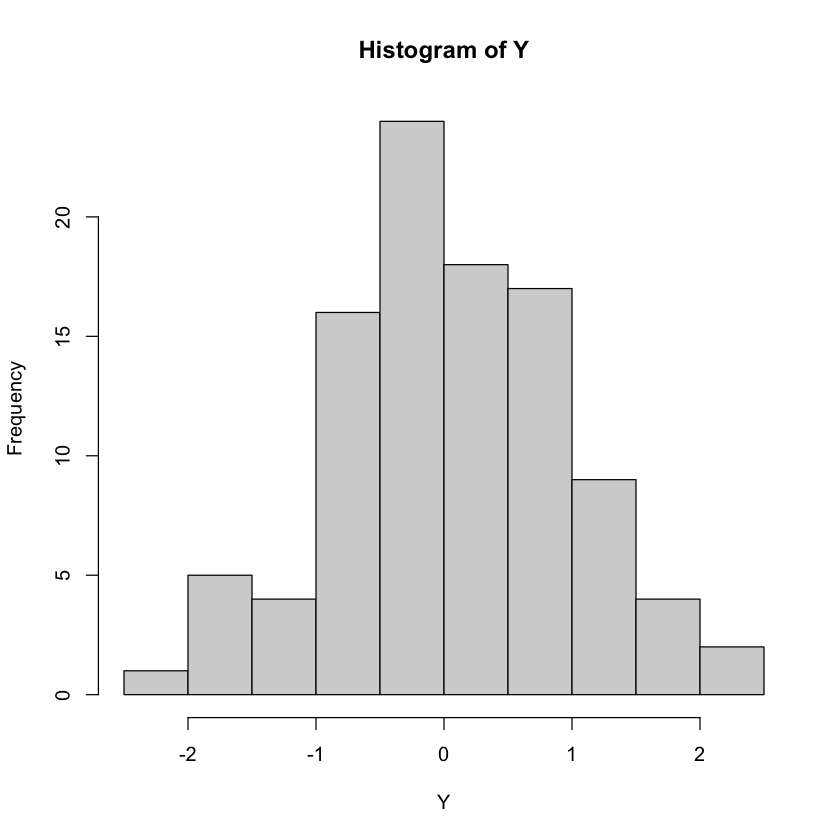

In [271]:
# combine components into final phenotype
Y <- genFixed_independent_scaled$component + noiseBg_independent_scaled$component
summary(Y)
hist(Y)


# Reproduction?

Let's assume individual 30 mates 40:

In [272]:
# What would be the new genotype info? 
# A simple mathematical rule?
snps = colnames(genotypes$genotypes)
couple = data.table(t(genotypes$genotypes[c(30, 40), ]))
rownames(couple) = snps
couple

,ID_30,ID_40
,<int>,<int>
SNP_1,0,0
SNP_2,0,1
SNP_3,0,2
SNP_4,0,0
SNP_5,1,1
SNP_6,0,0
SNP_7,0,2
SNP_8,0,1
SNP_9,1,1


In [273]:
# mendelian rules
m = matrix(c(1, 0, 0, 0.5, 0.5, 0, 0, 1, 0, 0.25, 0.50, 0.25, 0, 0.50, 0.5, 0, 0, 1), 
    nrow = 6, ncol = 3, byrow  = TRUE
) 
colnames(m) = c(0, 1, 2)
rownames(m) = c("00", "01", "02", "11", "12", "22")
m

,0,1,2
00,1.00,0.0,0.00
01,0.50,0.5,0.00
02,0.00,1.0,0.00
11,0.25,0.5,0.25
12,0.00,0.5,0.50
22,0.00,0.0,1.00


In [274]:
# function to get offspring genotype
getGenotype = function(father, mother, matrix) {
    comba = paste0(father, mother, collapse = "")
    combb = paste0(mother, father, collapse = "")
    s = grep(paste0(comba, "|", combb), rownames(matrix))
    prob = as.vector(matrix[s, ])
    return(sample(0:2, size = 1, prob = prob))
}

# getGenotype(2, 2, m)

In [279]:
couple[, ID_NEW := getGenotype(ID_30, ID_40, m), by = seq_len(nrow(couple))]
couple[, SNP_ID := rownames(couple)]
head(couple)

ID_30,ID_40,ID_NEW,SNP_ID
<int>,<int>,<int>,<chr>
0,0,0,SNP_1
0,1,0,SNP_2
0,2,1,SNP_3
0,0,0,SNP_4
1,1,1,SNP_5
0,0,0,SNP_6


In [280]:
# compute phenotype
genV = matrix(couple[SNP_ID %in% colnames(causalSNPs), ID_NEW], byrow = TRUE, nrow = 1, 10) %*% t(genFixed$cov_effect)
noiseV = rnorm(1, mean = 0, sd = 1)

In [281]:
newY <- genV * genVar + noiseV * (1-genVar)
newY

Trait_1
0.6580801


In [282]:
# parents phenotype
Y[c(30, 40)]

[1]  0.5846302 -1.6227281